In [1]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def cnn_history_parser(path="metrics.txt"):
    with open(path, "r") as f:
        lines = f.read().splitlines()

    groups = []
    cur = []

    for line in lines:
        if line.strip() == "cuda":
            if cur:
                groups.append(cur)
            cur = [line]
        else:
            if cur:
                cur.append(line)
    if cur:
        groups.append(cur)

    history = {}

    for g in groups:
        saved_line = None
        for line in reversed(g):
            line = line.strip()
            if line.startswith("Saved:"):
                saved_line = line
                break
        if not saved_line:
            continue

        m = re.match(r"Saved:\s+(\S+)_lambda-([0-9.]+)\.pth", saved_line)
        if not m:
            continue

        model_name = m.group(1)
        lam = float(m.group(2))

        if model_name not in history:
            history[model_name] = {}

        if lam not in history[model_name]:
            history[model_name][lam] = {
                "epoch": [],
                "train_acc": [],
                "val_acc": [],
            }

        for line in g:
            line = line.strip()
            m2 = re.match(
                r"lambda: [0-9.]+ and epoch: (\d+) of (\d+), "
                r"train accuracy: ([0-9.]+) and val accuracy: ([0-9.]+)",
                line
            )
            if m2:
                epoch = int(m2.group(1))
                train_acc = float(m2.group(3))
                val_acc = float(m2.group(4))

                history[model_name][lam]["epoch"].append(epoch)
                history[model_name][lam]["train_acc"].append(train_acc)
                history[model_name][lam]["val_acc"].append(val_acc)

    return history


In [3]:
histmap = cnn_history_parser("metrics.txt")
print(histmap.keys())
histmap["CNN"].keys()

dict_keys(['CNN', 'CNN-Turbo', 'CNN-Ultra', 'CNN-Lite'])


dict_keys([0.0, 0.01, 0.001, 0.005, 0.0001, 0.0005])

In [4]:
import matplotlib.pyplot as plt

def plot_model_lambdas(history, model_name, rows=2, cols=3):

    lambdas = sorted(history[model_name].keys())

    plt.figure(figsize=(17, 11))

    for i, lam in enumerate(lambdas):
        h = history[model_name][lam]
        epochs = h["epoch"]
        train_acc = h["train_acc"]
        val_acc = h["val_acc"]

        ax = plt.subplot(rows, cols, i+1)
        ax.plot(epochs, train_acc, label="train accuracy")
        ax.plot(epochs, val_acc, label="val accuracy")

        ax.set_title(f"lambda = {lam}", fontsize=15)
        ax.set_xlabel("epoch")
        ax.set_ylabel("accuracy")
        ax.set_ylim(0.1, 1)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


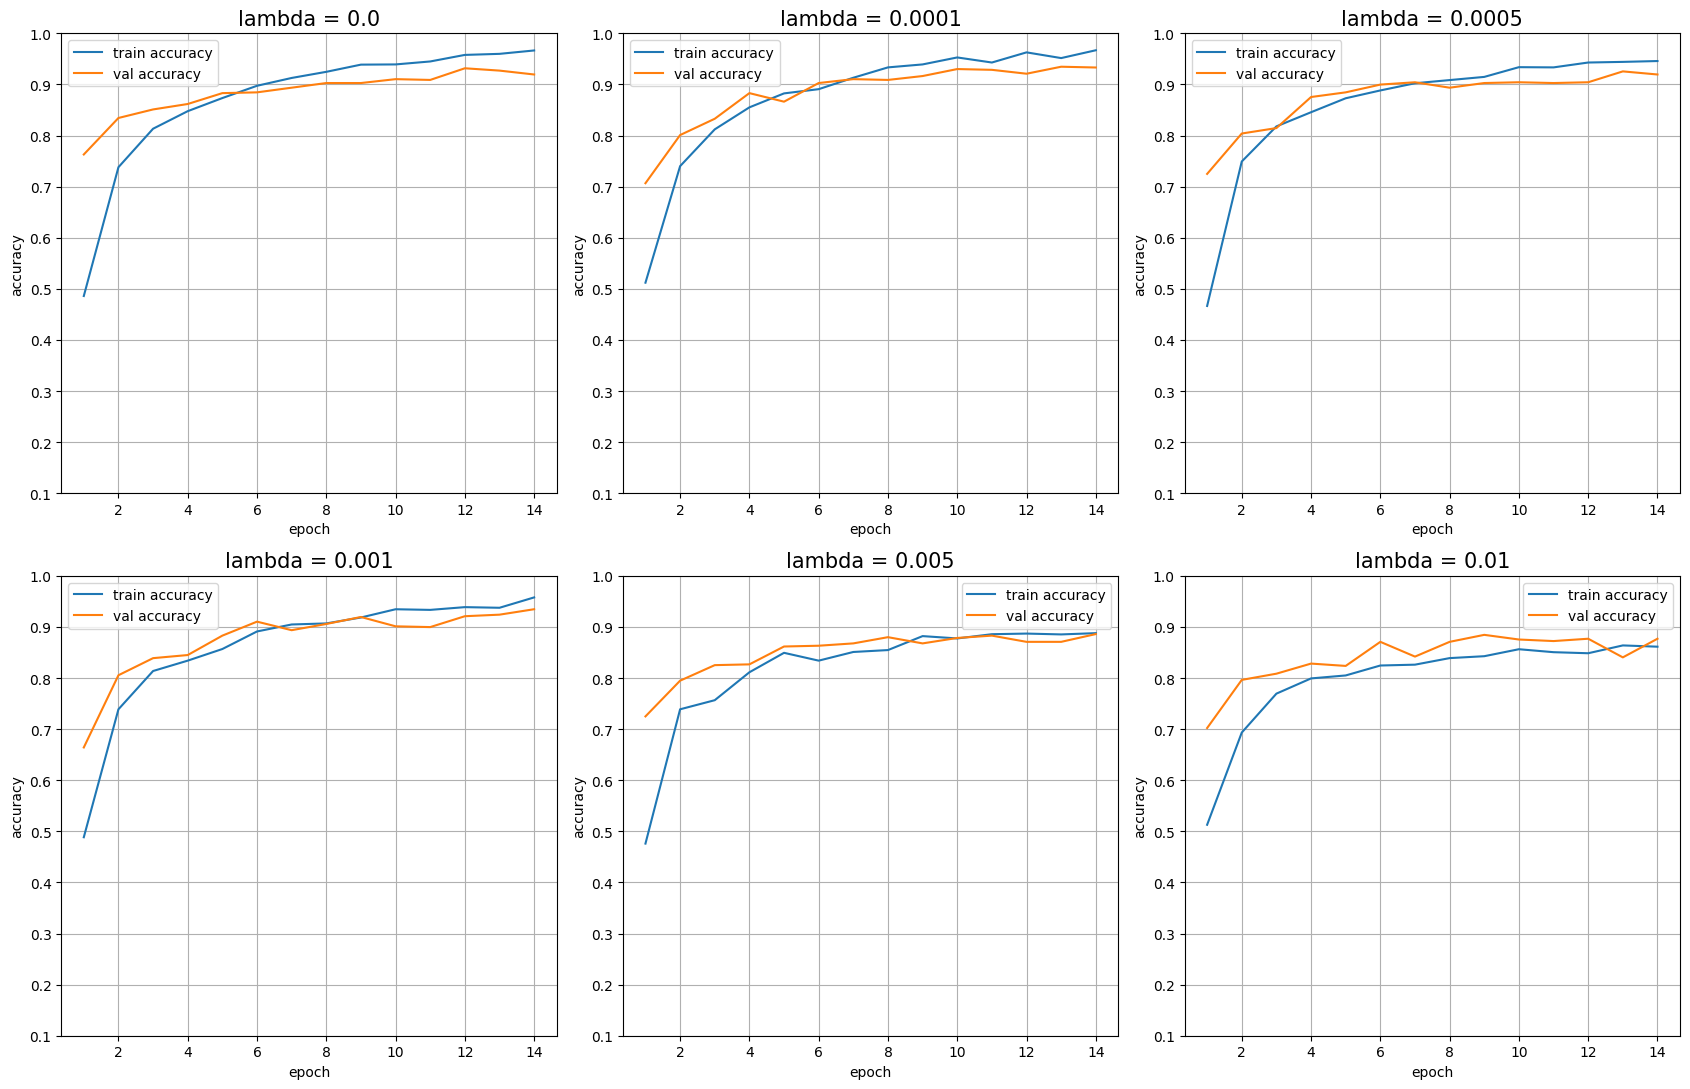

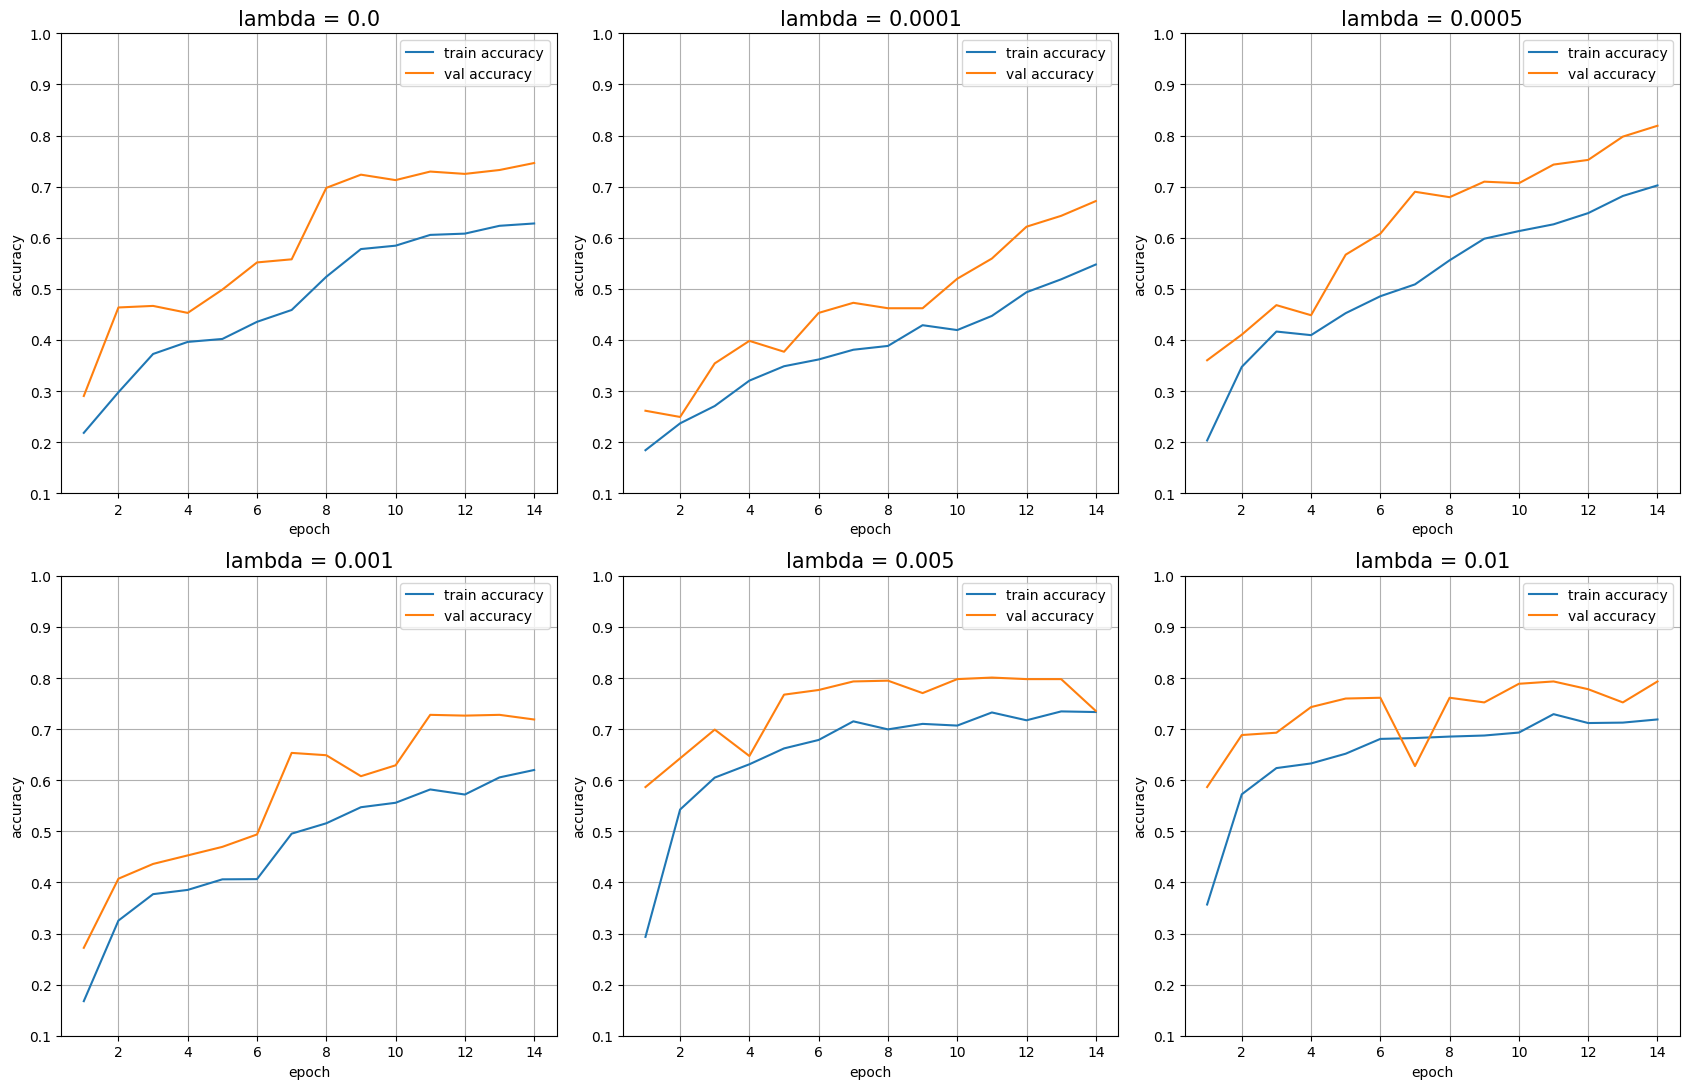

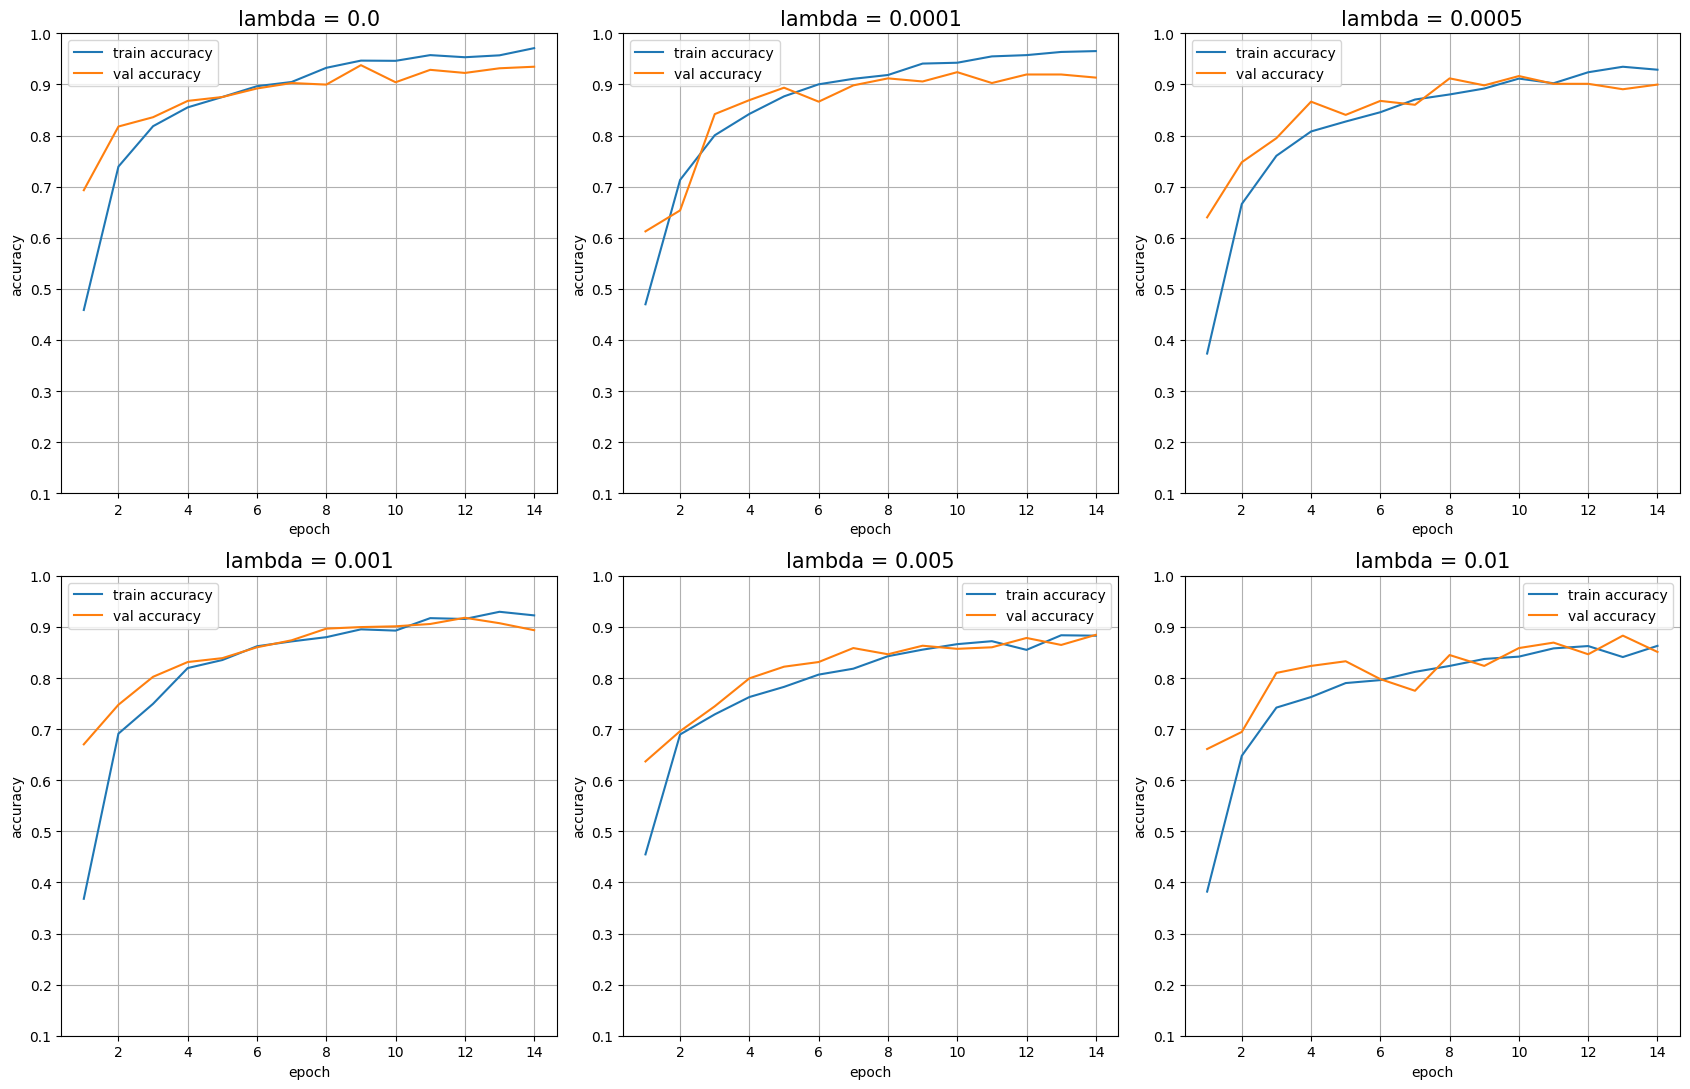

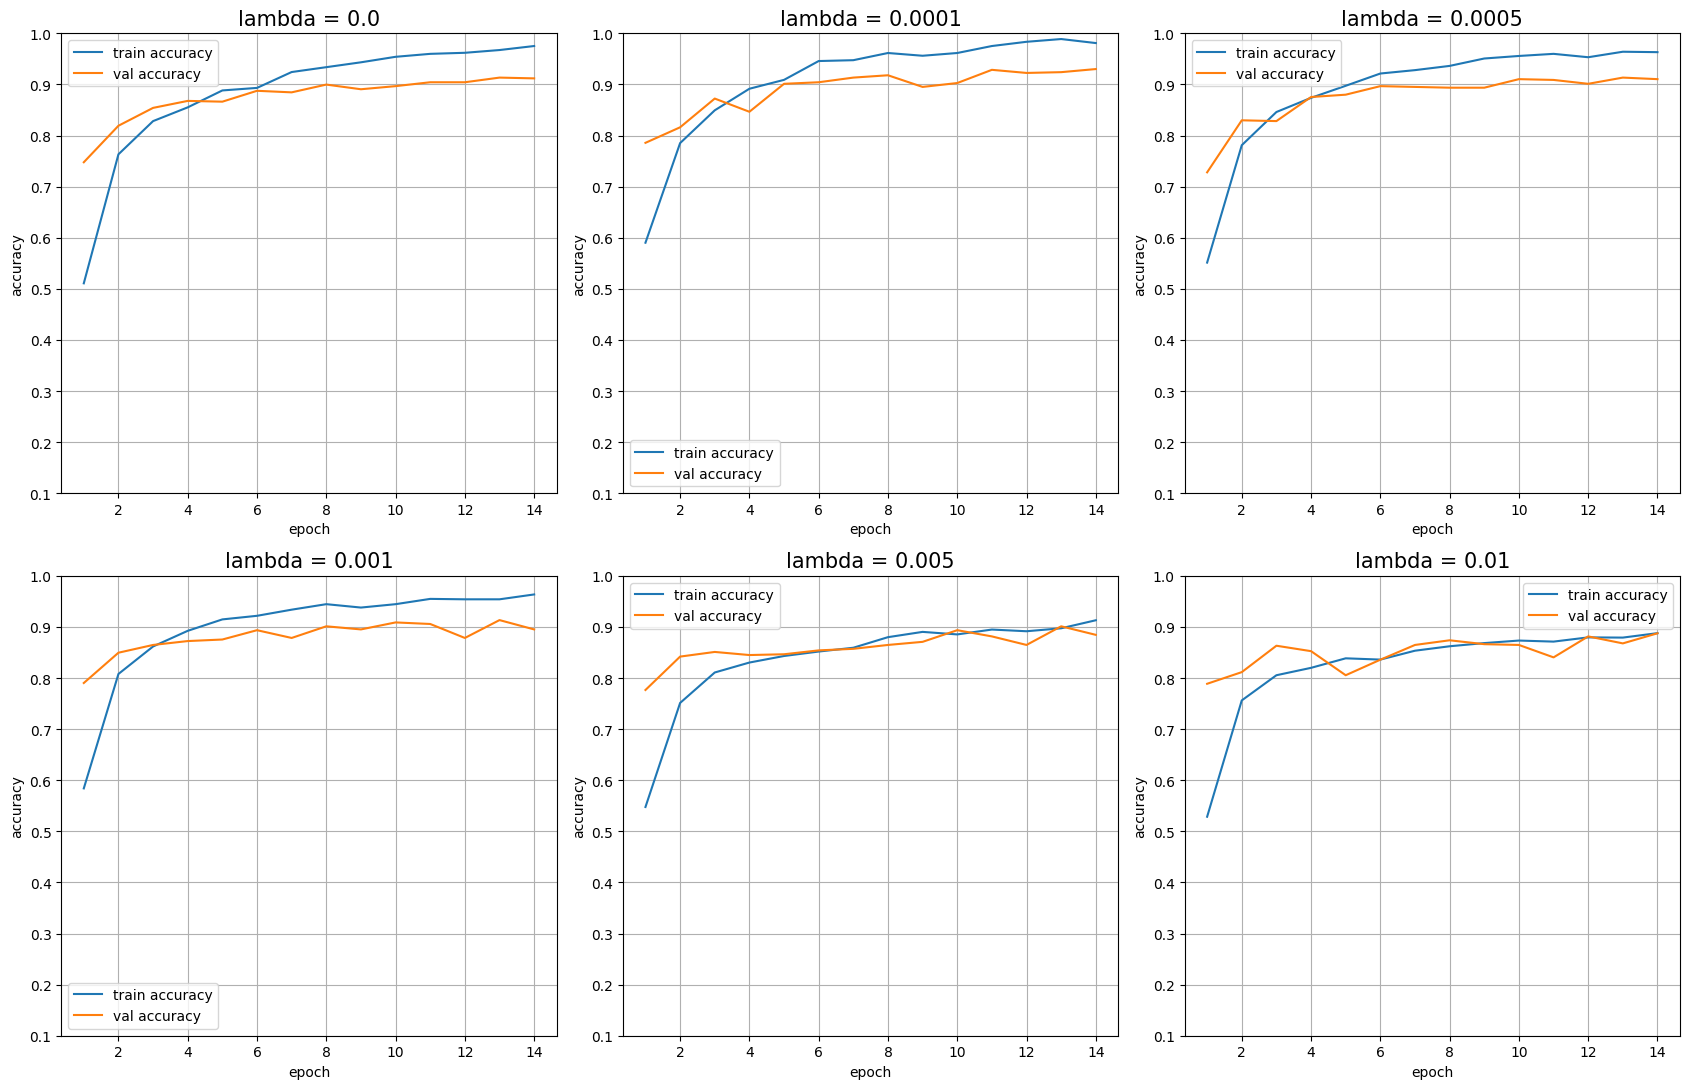

In [5]:
plot_model_lambdas(histmap, "CNN")
plot_model_lambdas(histmap, "CNN-Turbo")
plot_model_lambdas(histmap, "CNN-Ultra")
plot_model_lambdas(histmap, "CNN-Lite")

In [6]:
import pandas as pd

def res_table(histmap, model):
    lambdas = sorted(histmap[model].keys())
    r = list()

    for lam in lambdas:
        h = histmap[model][lam]
        train_acc = h["train_acc"][-1]
        val_acc = h["val_acc"][-1]
        r.append((lam, train_acc, val_acc))
    return pd.DataFrame(r, columns=["lambda", "train accuracy", "val accuracy"])

In [7]:
base_table = res_table(histmap, "CNN")
base_table

,lambda,train accuracy,val accuracy
0,0.0000,0.966474,0.919453
1,0.0001,0.966887,0.933131
2,0.0005,0.945778,0.919453
3,0.0010,0.957781,0.934650
4,0.0050,0.887831,0.886018
5,0.0100,0.861341,0.876900


In [8]:
ultra_table = res_table(histmap, "CNN-Ultra")
ultra_table

,lambda,train accuracy,val accuracy
0,0.0000,0.971026,0.934650
1,0.0001,0.965232,0.913374
2,0.0005,0.928808,0.899696
3,0.0010,0.922599,0.893617
4,0.0050,0.882864,0.884498
5,0.0100,0.862997,0.851064


In [9]:
lite_table = res_table(histmap, "CNN-Lite")
lite_table

,lambda,train accuracy,val accuracy
0,0.0000,0.975166,0.911854
1,0.0001,0.980960,0.930091
2,0.0005,0.963162,0.910334
3,0.0010,0.963576,0.895137
4,0.0050,0.913079,0.884498
5,0.0100,0.887831,0.887538


In [10]:
turbo_table = res_table(histmap, "CNN-Turbo")
turbo_table

,lambda,train accuracy,val accuracy
0,0.0000,0.627897,0.746201
1,0.0001,0.547599,0.671733
2,0.0005,0.702401,0.819149
3,0.0010,0.620033,0.718845
4,0.0050,0.733444,0.735562
5,0.0100,0.718957,0.793313


In [11]:
import numpy as np

def best_lamb(histmap, model_name="CNN"):
    lambdas = histmap[model_name].keys()
    best_lam = max(
        lambdas,
        key=lambda lam: histmap[model_name][lam]["val_acc"][-1]
    )
    best_val_acc = histmap[model_name][best_lam]["val_acc"][-1]
    return best_lam, best_val_acc


In [12]:
def find_best_lamb(history_map, model_name="CNN"):
    best_lamb = -1
    best_val_acc = 0

    for lamb in history_map[model_name]:
        val_acc_list = history_map[model_name][lamb]["val_acc"]

        if len(val_acc_list) == 0:
            continue

        final_val_acc = val_acc_list[-1]
    
        if final_val_acc > best_val_acc:
            best_val_acc = final_val_acc
            best_lamb = lamb

    return best_lamb, best_val_acc

In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes, img_sz):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, padding=1, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, padding=1, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, padding=1, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)

        total_nodes = 256*int(img_sz/8)**2

        self.layer1 = nn.Linear(total_nodes, 256)
        self.dropout = nn.Dropout(0.35)

        self.layer2 = nn.Linear(256, num_classes)

    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)

        return x


In [14]:
class CNN_Ultra(nn.Module):
    def __init__(self, num_classes, img_sz):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, padding=1, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, padding=1, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, padding=1, kernel_size=3)
        self.conv4 = nn.Conv2d(256, 512,  padding=1, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)

        total_nodes = 512*int(img_sz/8)**2

        self.layer1 = nn.Linear(total_nodes, 512)
        self.dropout = nn.Dropout(0.3)

        self.layer2 = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = F.relu(x)

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)

        return x


In [15]:
class CNN_Turbo(nn.Module):
    def __init__(self, num_classes, img_sz):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, padding=1, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)

        total_nodes = 64*int(img_sz/2)**2

        self.layer1 = nn.Linear(total_nodes, 64)
        self.dropout = nn.Dropout(0.15)

        self.layer2 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = F.relu(x)
        
        x = self.dropout(x)

        x = self.layer2(x)

        return x


In [16]:
class CNN_Lite(nn.Module):
    def __init__(self, num_classes, img_sz):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, padding=1, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, padding=1, kernel_size=3)
        self.pool = nn.MaxPool2d(2,2)

        total_nodes = 128*int(img_sz/4)**2

        self.layer1 = nn.Linear(total_nodes, 128)
        self.dropout = nn.Dropout(0.2)

        self.layer2 = nn.Linear(128, num_classes)

    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)

        return x


In [17]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda")
print(device)

DATA_PATH = "../data/astro_dataset_maxia/astro_dataset_maxia"
image_sz = 128

train_transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

eval_transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

train_data = datasets.ImageFolder(os.path.join(DATA_PATH, "training"), transform=train_transform)
val_data   = datasets.ImageFolder(os.path.join(DATA_PATH, "validation"), transform=eval_transform)
test_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "test"),      transform=eval_transform)

print("Classes:", train_data.classes)
print("Number of Classes:", len(train_data.classes))
print("Training Samples:", len(train_data))
print("Val Samples:", len(val_data))
print("Test Samples:", len(test_data))
print("Total Samples:", len(train_data) + len(val_data) + len(test_data))

batch_size = 32 

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)


cuda
Classes: ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']
Number of Classes: 12
Training Samples: 2416
Val Samples: 658
Test Samples: 345
Total Samples: 3419


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1   = f1_score(all_labels, all_preds, average="macro")
    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro")
    rec  = recall_score(all_labels, all_preds, average="macro")

    return acc, prec, rec, f1



In [19]:
best_lam, best_val_acc = best_lamb(histmap, "CNN")

In [20]:
BEST_MODEL_PATH = f"CNN_lambda-{best_lam}.pth"
device = torch.device("cuda")
print(device)

num_classes = 12
img_sz = 128

best_model = CNN(num_classes=num_classes, img_sz=img_sz).to(device)

state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
best_model.load_state_dict(state_dict)

best_model.eval()

cuda


C:\Users\Owner\AppData\Local\Temp\ipykernel_20952\1848583682.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(BEST_MODEL_PATH, map_location=devic

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Linear(in_features=65536, out_features=256, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (layer2): Linear(in_features=256, out_features=12, bias=True)
)

In [ ]:
test_acc, test_precision, test_recall, test_f1 = evaluate_classification_model(best_model, test_loader, device)

print("Best lambda:", best_lam,
      "\nVal Accuracy:", best_val_acc,
      "\nTest Accuracy:", test_acc,
      "\nTest Precision:", test_precision,
      "\nTest Recall:", test_recall,
      "\nTest F1:", test_f1)

Best lambda: 0.001 
Val Accuracy: 0.9346504559270516 
Test Accuracy: 0.9333333333333333 
Test Precision: 0.9368229820663898 
Test Rec: 0.9331232233345692 
Test F1: 0.9335594390190914


In [22]:
best_lam, best_val_acc = best_lamb(histmap, "CNN-Ultra")
best_lam

0.0

In [23]:
BEST_MODEL_PATH = f"CNN-Ultra_lambda-0.pth"
device = torch.device("cuda")
print(device)

num_classes = 12
img_sz = 128

best_model = CNN_Ultra(num_classes=num_classes, img_sz=img_sz).to(device)

state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
best_model.load_state_dict(state_dict)

best_model.eval()

cuda


C:\Users\Owner\AppData\Local\Temp\ipykernel_20952\3889874080.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(BEST_MODEL_PATH, map_location=devic

CNN_Ultra(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Linear(in_features=131072, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=512, out_features=12, bias=True)
)

In [ ]:
test_acc, test_precision, test_recall, test_f1 = evaluate_classification_model(best_model, test_loader, device)

print("Best lambda:", best_lam,
      "\nVal Accuracy:", best_val_acc,
      "\nTest Accuracy:", test_acc,
      "\nTest Precision:", test_precision,
      "\nTest Recall:", test_recall,
      "\nTest F1:", test_f1)

Best lambda: 0.0 
Val Accuracy: 0.9346504559270516 
Test Accuracy: 0.9217391304347826 
Test Precision: 0.9305189708386546 
Test Rec: 0.9222180288503979 
Test F1: 0.9240370896008833


In [25]:
best_lam, best_val_acc = best_lamb(histmap, "CNN-Lite")

BEST_MODEL_PATH = f"CNN-Lite_lambda-{best_lam}.pth"
device = torch.device("cuda")
print(device)

num_classes = 12
img_sz = 128

best_model = CNN_Lite(num_classes=num_classes, img_sz=img_sz).to(device)

state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
best_model.load_state_dict(state_dict)

best_model.eval()

test_acc, test_precision, test_recall, test_f1 = evaluate_classification_model(best_model, test_loader, device)

print("Best lambda:", best_lam,
      "\nVal Acc:", best_val_acc,
      "\nTest Acc:", test_acc,
      "\nTest F1:", test_f1,
      "\nTest Precision:", test_precision,
      "\nTest Recall:", test_recall
)

cuda


C:\Users\Owner\AppData\Local\Temp\ipykernel_20952\3106767773.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(BEST_MODEL_PATH, map_location=devic

Best lambda: 0.0001 
Val Acc: 0.9300911854103343 
Test Acc: 0.9333333333333333 
Test F1: 0.9331659383641625 
Test Precision: 0.9359146839750289 
Test Recall: 0.9333414993732011


In [27]:
best_lam, best_val_acc = best_lamb(histmap, "CNN-Turbo")

BEST_MODEL_PATH = f"CNN-Turbo_lambda-{best_lam}.pth"
device = torch.device("cuda")
print(device)

num_classes = 12
img_sz = 128

best_model = CNN_Turbo(num_classes=num_classes, img_sz=img_sz).to(device)

state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
best_model.load_state_dict(state_dict)

best_model.eval()

test_acc, test_precision, test_recall, test_f1 = evaluate_classification_model(best_model, test_loader, device)

print("Best lambda:", best_lam,
      "\nVal Acc:", best_val_acc,
      "\nTest Acc:", test_acc,
      "\nTest F1:", test_f1,
      "\nTest Precision:", test_precision,
      "\nTest Recall:", test_recall
)

cuda


C:\Users\Owner\AppData\Local\Temp\ipykernel_20952\3720458589.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(BEST_MODEL_PATH, map_location=devic

Best lambda: 0.0005 
Val Acc: 0.8191489361702128 
Test Acc: 0.8405797101449275 
Test F1: 0.8427668044150488 
Test Precision: 0.8652788565549994 
Test Recall: 0.8405130480074862


In [28]:
def build_model(model_name, num_classes, img_sz):
    if model_name == "CNN":
        return CNN(num_classes=num_classes, img_sz=img_sz)
    elif model_name == "CNN-Turbo":
        return CNN_Turbo(num_classes=num_classes, img_sz=img_sz)
    elif model_name == "CNN-Ultra":
        return CNN_Ultra(num_classes=num_classes, img_sz=img_sz)
    elif model_name == "CNN-Lite":
        return CNN_Lite(num_classes=num_classes, img_sz=img_sz)

In [33]:
import pandas as pd

num_classes = len(train_data.classes)
rows = list()

for specific_model in histmap:
    for lam in sorted(histmap[specific_model]):
        model = build_model(specific_model, num_classes, image_sz).to(device)

        if float(lam) == 0:
            lam_str = '0'
        else:
            lam_str = str(lam)

        ckpt_path = f"{specific_model}_lambda-{lam_str}.pth"
        state_dict = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval()

        train_acc = histmap[specific_model][lam]["train_acc"][-1]
        val_acc   = histmap[specific_model][lam]["val_acc"][-1]

        test_acc, test_prec, test_rec, test_f1 = evaluate_classification_model(model, test_loader, device)

        rows.append({
            "model": specific_model,
            "lambda": lam,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "test_acc": test_acc,
            "test_precision": test_prec,
            "test_recall": test_rec,
            "test_f1": test_f1
        })

table = pd.DataFrame(rows)
table


C:\Users\Owner\AppData\Local\Temp\ipykernel_20952\747939786.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=device)
C:\U

,model,lambda,train_acc,val_acc,test_acc,test_precision,test_recall,test_f1
0,CNN,0.0000,0.966474,0.919453,0.939130,0.943946,0.938595,0.940190
1,CNN,0.0001,0.966887,0.933131,0.942029,0.946292,0.942161,0.943270
2,CNN,0.0005,0.945778,0.919453,0.907246,0.915660,0.907509,0.908330
3,CNN,0.0010,0.957781,0.934650,0.933333,0.936823,0.933123,0.933559
4,CNN,0.0050,0.887831,0.886018,0.863768,0.877580,0.864756,0.864240
5,CNN,0.0100,0.861341,0.876900,0.855072,0.867569,0.857856,0.853648
6,CNN-Turbo,0.0000,0.627897,0.746201,0.689855,0.709102,0.696408,0.682095
7,CNN-Turbo,0.0001,0.547599,0.671733,0.686957,0.713262,0.694549,0.675753
8,CNN-Turbo,0.0005,0.702401,0.819149,0.840580,0.865279,0.840513,0.842767
9,CNN-Turbo,0.0010,0.620033,0.718845,0.733333,0.751675,0.734465,0.723375


In [39]:
table = table.sort_values(by=["model", "lambda"]).reset_index(drop=True)
table

,model,lambda,train_acc,val_acc,test_acc,test_precision,test_recall,test_f1
0,CNN,0.0000,0.966474,0.919453,0.939130,0.943946,0.938595,0.940190
1,CNN,0.0001,0.966887,0.933131,0.942029,0.946292,0.942161,0.943270
2,CNN,0.0005,0.945778,0.919453,0.907246,0.915660,0.907509,0.908330
3,CNN,0.0010,0.957781,0.934650,0.933333,0.936823,0.933123,0.933559
4,CNN,0.0050,0.887831,0.886018,0.863768,0.877580,0.864756,0.864240
5,CNN,0.0100,0.861341,0.876900,0.855072,0.867569,0.857856,0.853648
6,CNN-Lite,0.0000,0.975166,0.911854,0.918841,0.923064,0.918441,0.918332
7,CNN-Lite,0.0001,0.980960,0.930091,0.933333,0.935915,0.933341,0.933166
8,CNN-Lite,0.0005,0.963162,0.910334,0.913043,0.926894,0.912527,0.915548
9,CNN-Lite,0.0010,0.963576,0.895137,0.895652,0.904852,0.894856,0.891841


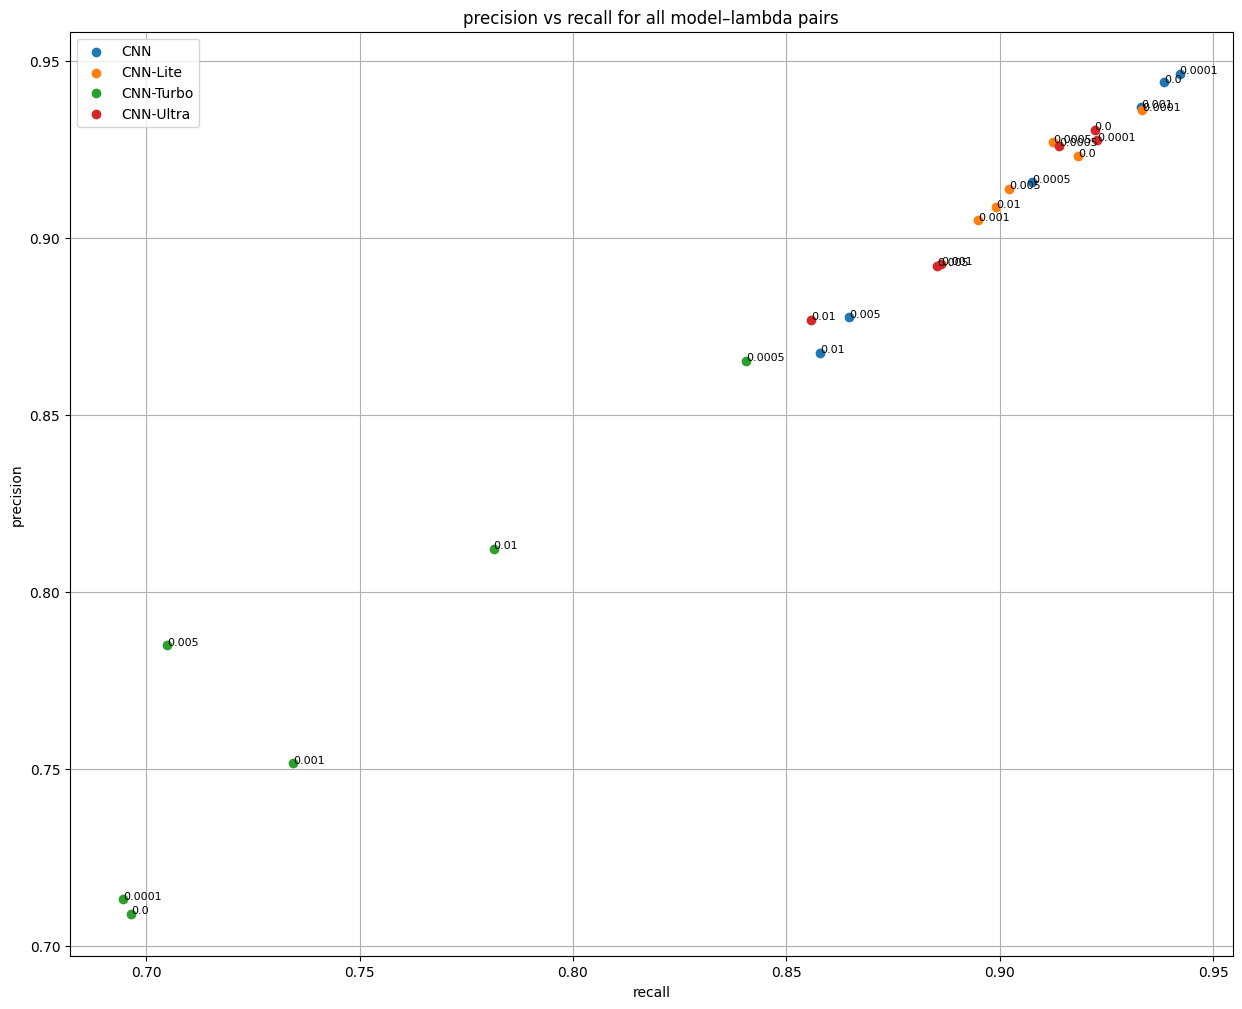

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

for model_name in table["model"].unique():
    subset = table[table["model"] == model_name]
    plt.scatter(subset["test_recall"], subset["test_precision"], label=model_name)
    for i, row in subset.iterrows():
        plt.text(row["test_recall"], row["test_precision"], str(row["lambda"]), fontsize=8)

plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision vs recall for all model–lambda pairs")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
table.to_excel("cnn_results.xlsx", index=False)
